# Parameters

In [20]:
data_path = '/content/drive/My Drive/LSTM/Data'
model_path = '/content/drive/My Drive/LSTM/Model'


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [22]:
!pip install transformers

In [23]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Pre-processing

In [25]:
n_words = 200
def trim_string(x):

    x = x.split(maxsplit=n_words)
    x = ' '.join(x[:n_words])

    return x

In [30]:
# Read raw data
df_raw = pd.read_csv('/content/drive/MyDrive/LSTM/news.csv', sep=',',encoding='utf-8', engine='python' )
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 


df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

train_test_ratio = 0.10
train_valid_ratio = 0.80

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)


# Write preprocessed data
df_train.to_csv(data_path + '/train.csv', index=False)
df_valid.to_csv(data_path + '/valid.csv', index=False)
df_test.to_csv(data_path + '/test.csv', index=False)

In [31]:
df_raw

,label,title,text,titletext
0,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear. Daniel Greenfiel...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy. U...
3,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matte...
...,...,...,...,...
6330,0,State Department says it can't find emails fro...,The State Department told the Republican Natio...,State Department says it can't find emails fro...
6331,1,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332,1,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligarc...
6333,0,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...","In Ethiopia, Obama seeks progress on peace, se..."


In [32]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=data_path, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

# Models

In [33]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

# Training

In [34]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [35]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = model_path,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                      labels = labels.to(device)
                      titletext = titletext.to(device)
                      titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [45]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [8/160], Train Loss: 0.7054, Valid Loss: 0.6736
Model saved to ==> /content/drive/My Drive/LSTM/Model/model.pt
Model saved to ==> /content/drive/My Drive/LSTM/Model/metrics.pt
Epoch [1/10], Step [16/160], Train Loss: 0.6783, Valid Loss: 0.6592
Model saved to ==> /content/drive/My Drive/LSTM/Model/model.pt
Model saved to ==> /content/drive/My Drive/LSTM/Model/metrics.pt
Epoch [2/10], Step [24/160], Train Loss: 0.5864, Valid Loss: 0.6458
Model saved to ==> /content/drive/My Drive/LSTM/Model/model.pt
Model saved to ==> /content/drive/My Drive/LSTM/Model/metrics.pt
Epoch [2/10], Step [32/160], Train Loss: 0.5943, Valid Loss: 0.6318
Model saved to ==> /content/drive/My Drive/LSTM/Model/model.pt
Model saved to ==> /content/drive/My Drive/LSTM/Model/metrics.pt
Epoch [3/10], Step [40/160], Train Loss: 0.4987, Valid Loss: 0.6175
Model saved to ==> /content/drive/My Drive/LSTM/Model/model.pt
Model saved to ==> /content/drive/My Drive/LSTM/Model/metrics.pt
Epoch [3/10], Step [4

Model loaded from <== /content/drive/My Drive/LSTM/Model/metrics.pt


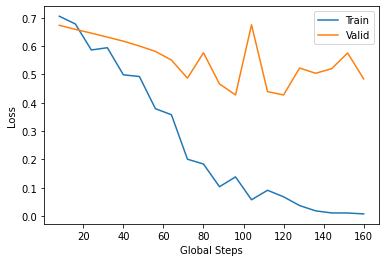

In [46]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [47]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Model loaded from <== /content/drive/My Drive/LSTM/Model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7321    0.7830    0.7567      2816
           0     0.7701    0.7172    0.7427      2854

    accuracy                         0.7499      5670
   macro avg     0.7511    0.7501    0.7497      5670
weighted avg     0.7512    0.7499    0.7497      5670



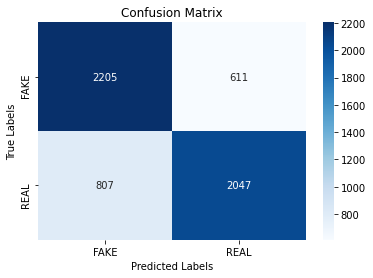

In [48]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(model_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)